In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

C:\Users\jvhua\Miniconda3\envs\tensflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [277]:
df = pd.read_csv('dfnitro3v2.csv', index_col = 0)

In [278]:
df.columns

Index(['new_date', 'CloudCover', 'HUC12', 'Latitude', 'Longitude', 'Method',
       'SampleDepth', 'SampleId', 'WindDirection', 'WindSpeed', 'HUC12_',
       'FIPS_', 'COUNTY_', 'STATE_', 'areaacres', 'za_mean', 'lc_11', 'lc_21',
       'lc_22', 'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52',
       'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'month', 'year', 'week',
       'dayofweek', 'hour', 'min', 'quarter', 'DO', 'TN', 'TP', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr', 'PH', 'SA',
       'of_dist'],
      dtype='object')

In [279]:
#choose location to predict total nitrogen for this 
df = df.loc[:,['areaacres', 'za_mean', 'lc_11', 'lc_21',
       'lc_22', 'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52',
       'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'of_dist', 'HUC12_', 'new_date', 'TN', 'week', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']]

In [280]:
df = df.set_index('new_date')

In [281]:
#preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold

#metrics
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

#algorithms 
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

#hyptertuning
from sklearn.model_selection import RandomizedSearchCV

#Scalers 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [282]:
df['HUC12_'] = df['HUC12_'].apply(lambda x: str(x))
df['week'] = df['week'].apply(lambda x: str(x))

In [430]:
print(df['TN'].mean())
df2 = df[df['TN'] < 50]


1.5488472383385055


In [ ]:
#KnnImputer 

In [431]:
knnimputer = KNNImputer(n_neighbors=2)

ohe = OneHotEncoder(handle_unknown='ignore')


scaler_min = MinMaxScaler()
scaler_max = MaxAbsScaler()
scaler_std = StandardScaler()
scaler_rob = RobustScaler()

knn_impute_scale = make_pipeline(knnimputer, scaler_rob)
knn_impute_scale2 = make_pipeline(knnimputer, scaler_std)
knn_impute_scale3 = make_pipeline(knnimputer, scaler_max)
knn_impute_scale4 = make_pipeline(knnimputer, scaler_min)

In [432]:
#robust scaler 
ct_rob = make_column_transformer(
    (knn_impute_scale, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [433]:
#minmax scaler 
ct_min = make_column_transformer(
    (knn_impute_scale4, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [434]:
#maxabs scaler 
ct_max = make_column_transformer(
    (knn_impute_scale3, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [435]:
#standard scaler 
ct_std = make_column_transformer(
    (knn_impute_scale2, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [436]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df2.drop(labels = 'TN', axis = 1), df2['TN'], test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((46909, 32), (20104, 32))

In [437]:
#Pipeline Creation 
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)

pipeline1 = make_pipeline(ct_rob, rf)
pipeline2 = make_pipeline(ct_min, rf)
pipeline3 = make_pipeline(ct_max, rf)
pipeline4 = make_pipeline(ct_std, rf)

In [438]:
#pipeline fitting Robust Scaler
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                              

In [439]:
#pipeline fitting MinMax Scaler
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                              

In [440]:
#pipeline fitting MaxAbs Scaler
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('maxabsscaler',
                                                                   MaxAbsScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                              

In [441]:
#pipeline fitting Standard Scaler
pipeline4.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                          

In [442]:
#pipeline prediction 
y_pred = pipeline1.predict(X_test)
y_pred2 = pipeline2.predict(X_test)
y_pred3 = pipeline3.predict(X_test)
y_pred4 = pipeline4.predict(X_test)

In [443]:
#Robust Scaler 
print(r2_score(y_test, y_pred))
print(explained_variance_score(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

#Feature importance Robust
for col, score in zip(X_train.columns, pipeline1['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.08441054338045717
0.09827441451990193
1.7137068302886507
areaacres = 0.00959995163032726
za_mean = 0.02892668528264773
lc_11 = 0.10390585302424743
lc_21 = 0.07254958784913389
lc_22 = 0.003964600056816575
lc_23 = 0.0030103497491149257
lc_24 = 0.004056740669683892
lc_31 = 0.04063996950143919
lc_41 = 0.022220095887005808
lc_42 = 0.005906587022102873
lc_43 = 0.02126607004794855
lc_52 = 0.04769390634658567
lc_71 = 0.013617181560009784
lc_81 = 0.022710190825024422
lc_82 = 0.15790508511877474
lc_90 = 0.018330308566241852
lc_95 = 0.01376407070721543
of_dist = 0.19876843658698168
HUC12_ = 0.017323716782998412
week = 0.006416898960932444
airtemp_narr = 0.01909238069117771
precip3_narr = 0.0063974511759044865
humidity_narr = 0.0009408387987465263
cl_cover_narr = 0.012800533321681174
sfc_runoff = 0.006863547545685236
sfc_air_narr = 0.0048124008382115415
u_wind_narr = 0.01463772261835446
v_wind_narr = 0.004829427637216788
windspeed_narr = 0.023823299746727526
wdirection_narr = 0.02009419078802861

In [444]:
#MinMaxScaler
print(r2_score(y_test, y_pred2))
print(explained_variance_score(y_test, y_pred2))
print(np.sqrt(mean_squared_error(y_test, y_pred2)))

#Feature importance MinMax
for col, score in zip(X_train.columns, pipeline2['randomforestregressor'].feature_importances_):
       print(col, "=", score)

-0.023361726366051494
0.04934108308165308
1.8117602265898516
areaacres = 0.00959995163032726
za_mean = 0.02892668528264773
lc_11 = 0.10390585302424743
lc_21 = 0.07254958784913389
lc_22 = 0.003964600056816575
lc_23 = 0.0030103497491149257
lc_24 = 0.004056740669683892
lc_31 = 0.04063996950143919
lc_41 = 0.022220095887005808
lc_42 = 0.005906587022102873
lc_43 = 0.02126607004794855
lc_52 = 0.04769390634658567
lc_71 = 0.013617181560009784
lc_81 = 0.022710190825024422
lc_82 = 0.15790508511877474
lc_90 = 0.018330308566241852
lc_95 = 0.01376407070721543
of_dist = 0.19876843658698168
HUC12_ = 0.017323716782998412
week = 0.006416898960932444
airtemp_narr = 0.01909238069117771
precip3_narr = 0.0063974511759044865
humidity_narr = 0.0009408387987465263
cl_cover_narr = 0.012800533321681174
sfc_runoff = 0.006863547545685236
sfc_air_narr = 0.0048124008382115415
u_wind_narr = 0.01463772261835446
v_wind_narr = 0.004829427637216788
windspeed_narr = 0.023823299746727526
wdirection_narr = 0.020094190788028

In [445]:
#MaxAbsScaler
print(r2_score(y_test, y_pred3))
print(explained_variance_score(y_test, y_pred3))
print(np.sqrt(mean_squared_error(y_test, y_pred3)))

#Feature importance MaxAbs
for col, score in zip(X_train.columns, pipeline3['randomforestregressor'].feature_importances_):
       print(col, "=", score)

-0.024034084072653616
0.04686696715507721
1.8123553001113626
areaacres = 0.00959995163032726
za_mean = 0.02892668528264773
lc_11 = 0.10390585302424743
lc_21 = 0.07254958784913389
lc_22 = 0.003964600056816575
lc_23 = 0.0030103497491149257
lc_24 = 0.004056740669683892
lc_31 = 0.04063996950143919
lc_41 = 0.022220095887005808
lc_42 = 0.005906587022102873
lc_43 = 0.02126607004794855
lc_52 = 0.04769390634658567
lc_71 = 0.013617181560009784
lc_81 = 0.022710190825024422
lc_82 = 0.15790508511877474
lc_90 = 0.018330308566241852
lc_95 = 0.01376407070721543
of_dist = 0.19876843658698168
HUC12_ = 0.017323716782998412
week = 0.006416898960932444
airtemp_narr = 0.01909238069117771
precip3_narr = 0.0063974511759044865
humidity_narr = 0.0009408387987465263
cl_cover_narr = 0.012800533321681174
sfc_runoff = 0.006863547545685236
sfc_air_narr = 0.0048124008382115415
u_wind_narr = 0.01463772261835446
v_wind_narr = 0.004829427637216788
windspeed_narr = 0.023823299746727526
wdirection_narr = 0.020094190788028

In [446]:
#StandardScaler
print(r2_score(y_test, y_pred4))
print(explained_variance_score(y_test, y_pred4))
print(np.sqrt(mean_squared_error(y_test, y_pred4)))

#Feature importance Standard 
for col, score in zip(X_train.columns, pipeline4['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.8333625119953084
0.8333627644868798
0.7310927737794299
areaacres = 0.00959995163032726
za_mean = 0.02892668528264773
lc_11 = 0.10390585302424743
lc_21 = 0.07254958784913389
lc_22 = 0.003964600056816575
lc_23 = 0.0030103497491149257
lc_24 = 0.004056740669683892
lc_31 = 0.04063996950143919
lc_41 = 0.022220095887005808
lc_42 = 0.005906587022102873
lc_43 = 0.02126607004794855
lc_52 = 0.04769390634658567
lc_71 = 0.013617181560009784
lc_81 = 0.022710190825024422
lc_82 = 0.15790508511877474
lc_90 = 0.018330308566241852
lc_95 = 0.01376407070721543
of_dist = 0.19876843658698168
HUC12_ = 0.017323716782998412
week = 0.006416898960932444
airtemp_narr = 0.01909238069117771
precip3_narr = 0.0063974511759044865
humidity_narr = 0.0009408387987465263
cl_cover_narr = 0.012800533321681174
sfc_runoff = 0.006863547545685236
sfc_air_narr = 0.0048124008382115415
u_wind_narr = 0.01463772261835446
v_wind_narr = 0.004829427637216788
windspeed_narr = 0.023823299746727526
wdirection_narr = 0.020094190788028612


In [447]:
#SimpleImputer Mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [448]:
#Imputers using the mean 
mean_impute_scale = make_pipeline(imp_mean, scaler_rob)
mean_impute_scale2 = make_pipeline(imp_mean, scaler_std)
mean_impute_scale3 = make_pipeline(imp_mean, scaler_max)
mean_impute_scale4 = make_pipeline(imp_mean, scaler_min)

In [449]:
#robust scaler 
ct_rob_m = make_column_transformer(
    (mean_impute_scale, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [450]:
#minmax scaler 
ct_min_m = make_column_transformer(
    (mean_impute_scale2, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [451]:
#maxabs scaler 
ct_max_m = make_column_transformer(
    (mean_impute_scale3, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [452]:
#standard scaler 
ct_std_m = make_column_transformer(
    (mean_impute_scale2, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [453]:
#Pipeline Creation 
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)

pipeline1m = make_pipeline(ct_rob_m, rf)
pipeline2m = make_pipeline(ct_min_m, rf)
pipeline3m = make_pipeline(ct_max_m, rf)
pipeline4m = make_pipeline(ct_std_m, rf)

In [454]:
pipeline1m.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                                     

In [455]:
pipeline2m.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                                 

In [456]:
pipeline3m.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('maxabsscaler',
                                                                   MaxAbsScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                                     

In [457]:
pipeline4m.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                                 

In [458]:
#pipeline prediction 
y_predm = pipeline1.predict(X_test)
y_pred2m = pipeline2.predict(X_test)
y_pred3m = pipeline3.predict(X_test)
y_pred4m = pipeline4.predict(X_test)

In [459]:
#Robust Scaler 
print(r2_score(y_test, y_predm))
print(explained_variance_score(y_test, y_predm))
print(np.sqrt(mean_squared_error(y_test, y_predm)))

#Feature importance Robust
for col, score in zip(X_train.columns, pipeline1m['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.08441054338045717
0.09827441451990215
1.7137068302886507
areaacres = 0.023892288656150906
za_mean = 0.021923103881349475
lc_11 = 0.08972279553482528
lc_21 = 0.0565704987546872
lc_22 = 0.004792763119063532
lc_23 = 0.0023742602285572972
lc_24 = 0.006686492691835753
lc_31 = 0.01661237082140049
lc_41 = 0.0062580826164085925
lc_42 = 0.005459310824676496
lc_43 = 0.06438055550194267
lc_52 = 0.013538027646303095
lc_71 = 0.010666004178210956
lc_81 = 0.024680998078756636
lc_82 = 0.16478331070324806
lc_90 = 0.044925645303169
lc_95 = 0.005995614964587285
of_dist = 0.11014212879072141
HUC12_ = 0.01811858257159417
week = 0.006953512110496908
airtemp_narr = 0.014073577647068925
precip3_narr = 0.006727587460991466
humidity_narr = 0.0008938271768891005
cl_cover_narr = 0.01339409177385595
sfc_runoff = 0.006879277867265859
sfc_air_narr = 0.005527594976872784
u_wind_narr = 0.013318723709377618
v_wind_narr = 0.0046844206071895555
windspeed_narr = 0.020167472678115417
wdirection_narr = 0.02299147729566757

In [460]:
#Min Max 
print(r2_score(y_test, y_pred2m))
print(explained_variance_score(y_test, y_pred2m))
print(np.sqrt(mean_squared_error(y_test, y_pred2m)))

#Feature importance
for col, score in zip(X_train.columns, pipeline2m['randomforestregressor'].feature_importances_):
       print(col, "=", score)

-0.023361726366051494
0.04934108308165308
1.8117602265898516
areaacres = 0.023892288656150906
za_mean = 0.021923103881349475
lc_11 = 0.08972279553482528
lc_21 = 0.0565704987546872
lc_22 = 0.004792763119063532
lc_23 = 0.0023742602285572972
lc_24 = 0.006686492691835753
lc_31 = 0.01661237082140049
lc_41 = 0.0062580826164085925
lc_42 = 0.005459310824676496
lc_43 = 0.06438055550194267
lc_52 = 0.013538027646303095
lc_71 = 0.010666004178210956
lc_81 = 0.024680998078756636
lc_82 = 0.16478331070324806
lc_90 = 0.044925645303169
lc_95 = 0.005995614964587285
of_dist = 0.11014212879072141
HUC12_ = 0.01811858257159417
week = 0.006953512110496908
airtemp_narr = 0.014073577647068925
precip3_narr = 0.006727587460991466
humidity_narr = 0.0008938271768891005
cl_cover_narr = 0.01339409177385595
sfc_runoff = 0.006879277867265859
sfc_air_narr = 0.005527594976872784
u_wind_narr = 0.013318723709377618
v_wind_narr = 0.0046844206071895555
windspeed_narr = 0.020167472678115417
wdirection_narr = 0.022991477295667

In [461]:
#Maxabs
print(r2_score(y_test, y_pred3m))
print(explained_variance_score(y_test, y_pred3m))
print(np.sqrt(mean_squared_error(y_test, y_pred3m)))

#Feature importance 
for col, score in zip(X_train.columns, pipeline3m['randomforestregressor'].feature_importances_):
       print(col, "=", score)

-0.024034084072653616
0.04686696715507721
1.8123553001113626
areaacres = 0.023892288656150906
za_mean = 0.021923103881349475
lc_11 = 0.08972279553482528
lc_21 = 0.0565704987546872
lc_22 = 0.004792763119063532
lc_23 = 0.0023742602285572972
lc_24 = 0.006686492691835753
lc_31 = 0.01661237082140049
lc_41 = 0.0062580826164085925
lc_42 = 0.005459310824676496
lc_43 = 0.06438055550194267
lc_52 = 0.013538027646303095
lc_71 = 0.010666004178210956
lc_81 = 0.024680998078756636
lc_82 = 0.16478331070324806
lc_90 = 0.044925645303169
lc_95 = 0.005995614964587285
of_dist = 0.11014212879072141
HUC12_ = 0.01811858257159417
week = 0.006953512110496908
airtemp_narr = 0.014073577647068925
precip3_narr = 0.006727587460991466
humidity_narr = 0.0008938271768891005
cl_cover_narr = 0.01339409177385595
sfc_runoff = 0.006879277867265859
sfc_air_narr = 0.005527594976872784
u_wind_narr = 0.013318723709377618
v_wind_narr = 0.0046844206071895555
windspeed_narr = 0.020167472678115417
wdirection_narr = 0.022991477295667

In [462]:
#StandardScaler 
print(r2_score(y_test, y_pred4m))
print(explained_variance_score(y_test, y_pred4m))
print(np.sqrt(mean_squared_error(y_test, y_pred4m)))

#Feature importance Robust
for col, score in zip(X_train.columns, pipeline4m['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.8333625119953084
0.8333627644868798
0.7310927737794299
areaacres = 0.023892288656150906
za_mean = 0.021923103881349475
lc_11 = 0.08972279553482528
lc_21 = 0.0565704987546872
lc_22 = 0.004792763119063532
lc_23 = 0.0023742602285572972
lc_24 = 0.006686492691835753
lc_31 = 0.01661237082140049
lc_41 = 0.0062580826164085925
lc_42 = 0.005459310824676496
lc_43 = 0.06438055550194267
lc_52 = 0.013538027646303095
lc_71 = 0.010666004178210956
lc_81 = 0.024680998078756636
lc_82 = 0.16478331070324806
lc_90 = 0.044925645303169
lc_95 = 0.005995614964587285
of_dist = 0.11014212879072141
HUC12_ = 0.01811858257159417
week = 0.006953512110496908
airtemp_narr = 0.014073577647068925
precip3_narr = 0.006727587460991466
humidity_narr = 0.0008938271768891005
cl_cover_narr = 0.01339409177385595
sfc_runoff = 0.006879277867265859
sfc_air_narr = 0.005527594976872784
u_wind_narr = 0.013318723709377618
v_wind_narr = 0.0046844206071895555
windspeed_narr = 0.020167472678115417
wdirection_narr = 0.02299147729566757
p

In [463]:
#Simple Iterative Imputer 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [464]:
iterative = IterativeImputer(random_state=0)

#Imputers using the mean 
iter_impute_scale = make_pipeline(iterative, scaler_rob)
iter_impute_scale2 = make_pipeline(iterative, scaler_std)
iter_impute_scale3 = make_pipeline(iterative, scaler_max)
iter_impute_scale4 = make_pipeline(iterative, scaler_min)

In [465]:
#robust scaler 
ct_rob_i = make_column_transformer(
    (iter_impute_scale, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [466]:
#minmax scaler 
ct_min_i = make_column_transformer(
    (iter_impute_scale4, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [467]:
#maxabs scaler 
ct_max_i = make_column_transformer(
    (iter_impute_scale3, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [468]:
#standard scaler 
ct_std_i = make_column_transformer(
    (iter_impute_scale2, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'of_dist', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [469]:
#Pipeline Creation 
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)

pipeline1i = make_pipeline(ct_rob_i, rf)
pipeline2i = make_pipeline(ct_min_i, rf)
pipeline3i = make_pipeline(ct_max_i, rf)
pipeline4i = make_pipeline(ct_std_i, rf)

In [470]:
pipeline1i.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(random_state=0)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                 

In [471]:
pipeline2i.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(random_state=0)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                 

In [472]:
pipeline3i.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(random_state=0)),
                                                                  ('maxabsscaler',
                                                                   MaxAbsScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'lc_95',
                 

In [473]:
pipeline4i.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(random_state=0)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_22',
                                                   'lc_23', 'lc_24', 'lc_31',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_52', 'lc_71', 'lc_81',
                                                   'lc_82', 'lc_90', 'l...
                

In [474]:
#pipeline prediction 
y_predi = pipeline1i.predict(X_test)
y_pred2i = pipeline2i.predict(X_test)
y_pred3i = pipeline3i.predict(X_test)
y_pred4i = pipeline4i.predict(X_test)

In [475]:
#Robust Scaler 
print(r2_score(y_test, y_predi))
print(explained_variance_score(y_test, y_predi))
print(np.sqrt(mean_squared_error(y_test, y_predi)))

#Feature importance Robust
for col, score in zip(X_train.columns, pipeline1i['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.06288715466750672
0.06420971577590218
1.7337324651862622
areaacres = 0.01895253778844007
za_mean = 0.0222982896898551
lc_11 = 0.0859136392012517
lc_21 = 0.05251735647452794
lc_22 = 0.005271671528493874
lc_23 = 0.0034474373723634923
lc_24 = 0.008168347536079527
lc_31 = 0.017415210463346556
lc_41 = 0.006256406987885197
lc_42 = 0.005765563390696897
lc_43 = 0.06346452806662137
lc_52 = 0.015514120998373617
lc_71 = 0.011255718989026222
lc_81 = 0.023460330058075587
lc_82 = 0.16710284397204916
lc_90 = 0.051439889220093245
lc_95 = 0.006285352280587285
of_dist = 0.11365007800276147
HUC12_ = 0.017513769447905347
week = 0.006422825377523364
airtemp_narr = 0.01424237984207286
precip3_narr = 0.006995893127766738
humidity_narr = 0.0008949538945054343
cl_cover_narr = 0.012519029829981909
sfc_runoff = 0.007867940475310479
sfc_air_narr = 0.0048600547004362775
u_wind_narr = 0.013256981350681185
v_wind_narr = 0.004900901606107336
windspeed_narr = 0.021184150720611177
wdirection_narr = 0.0234048271894322

In [476]:
#MinMax
print(r2_score(y_test, y_predi))
print(explained_variance_score(y_test, y_predi))
print(np.sqrt(mean_squared_error(y_test, y_predi)))

#Feature importance 
for col, score in zip(X_train.columns, pipeline2i['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.06288715466750672
0.06420971577590218
1.7337324651862622
areaacres = 0.01895253778844007
za_mean = 0.0222982896898551
lc_11 = 0.0859136392012517
lc_21 = 0.05251735647452794
lc_22 = 0.005271671528493874
lc_23 = 0.0034474373723634923
lc_24 = 0.008168347536079527
lc_31 = 0.017415210463346556
lc_41 = 0.006256406987885197
lc_42 = 0.005765563390696897
lc_43 = 0.06346452806662137
lc_52 = 0.015514120998373617
lc_71 = 0.011255718989026222
lc_81 = 0.023460330058075587
lc_82 = 0.16710284397204916
lc_90 = 0.051439889220093245
lc_95 = 0.006285352280587285
of_dist = 0.11365007800276147
HUC12_ = 0.017513769447905347
week = 0.006422825377523364
airtemp_narr = 0.01424237984207286
precip3_narr = 0.006995893127766738
humidity_narr = 0.0008949538945054343
cl_cover_narr = 0.012519029829981909
sfc_runoff = 0.007867940475310479
sfc_air_narr = 0.0048600547004362775
u_wind_narr = 0.013256981350681185
v_wind_narr = 0.004900901606107336
windspeed_narr = 0.021184150720611177
wdirection_narr = 0.0234048271894322

In [477]:
#MaxAbs
print(r2_score(y_test, y_predi))
print(explained_variance_score(y_test, y_predi))
print(np.sqrt(mean_squared_error(y_test, y_predi)))

#Feature importance 
for col, score in zip(X_train.columns, pipeline3i['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.06288715466750672
0.06420971577590218
1.7337324651862622
areaacres = 0.01895253778844007
za_mean = 0.0222982896898551
lc_11 = 0.0859136392012517
lc_21 = 0.05251735647452794
lc_22 = 0.005271671528493874
lc_23 = 0.0034474373723634923
lc_24 = 0.008168347536079527
lc_31 = 0.017415210463346556
lc_41 = 0.006256406987885197
lc_42 = 0.005765563390696897
lc_43 = 0.06346452806662137
lc_52 = 0.015514120998373617
lc_71 = 0.011255718989026222
lc_81 = 0.023460330058075587
lc_82 = 0.16710284397204916
lc_90 = 0.051439889220093245
lc_95 = 0.006285352280587285
of_dist = 0.11365007800276147
HUC12_ = 0.017513769447905347
week = 0.006422825377523364
airtemp_narr = 0.01424237984207286
precip3_narr = 0.006995893127766738
humidity_narr = 0.0008949538945054343
cl_cover_narr = 0.012519029829981909
sfc_runoff = 0.007867940475310479
sfc_air_narr = 0.0048600547004362775
u_wind_narr = 0.013256981350681185
v_wind_narr = 0.004900901606107336
windspeed_narr = 0.021184150720611177
wdirection_narr = 0.0234048271894322

In [478]:
#Standard
print(r2_score(y_test, y_predi))
print(explained_variance_score(y_test, y_predi))
print(np.sqrt(mean_squared_error(y_test, y_predi)))

#Feature importance 
for col, score in zip(X_train.columns, pipeline4i['randomforestregressor'].feature_importances_):
       print(col, "=", score)

0.06288715466750672
0.06420971577590218
1.7337324651862622
areaacres = 0.01895253778844007
za_mean = 0.0222982896898551
lc_11 = 0.0859136392012517
lc_21 = 0.05251735647452794
lc_22 = 0.005271671528493874
lc_23 = 0.0034474373723634923
lc_24 = 0.008168347536079527
lc_31 = 0.017415210463346556
lc_41 = 0.006256406987885197
lc_42 = 0.005765563390696897
lc_43 = 0.06346452806662137
lc_52 = 0.015514120998373617
lc_71 = 0.011255718989026222
lc_81 = 0.023460330058075587
lc_82 = 0.16710284397204916
lc_90 = 0.051439889220093245
lc_95 = 0.006285352280587285
of_dist = 0.11365007800276147
HUC12_ = 0.017513769447905347
week = 0.006422825377523364
airtemp_narr = 0.01424237984207286
precip3_narr = 0.006995893127766738
humidity_narr = 0.0008949538945054343
cl_cover_narr = 0.012519029829981909
sfc_runoff = 0.007867940475310479
sfc_air_narr = 0.0048600547004362775
u_wind_narr = 0.013256981350681185
v_wind_narr = 0.004900901606107336
windspeed_narr = 0.021184150720611177
wdirection_narr = 0.0234048271894322

In [479]:
#StandardScaler seems to do the best now to eliminate some features 
#knnimputer and simpleimputer with mean with standardscaler both had around the same score 

In [498]:
#Numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(X_train.select_dtypes(include = numerics).columns)
X_train_n = X_train[numerical_vars]

In [499]:
#Variability Threshold 

In [500]:
#Looking for Quasi-Constant observations that dont' show much variability. 
sel = VarianceThreshold(threshold = 0.001)
sel.fit(X_train_n)

VarianceThreshold(threshold=0.001)

In [501]:
#Features not quasiconstant 
sum(sel.get_support())

26

In [502]:
#These Features are quasi-constant and should be dropped 
[x for x in X_train_n.columns if x not in X_train_n.columns[sel.get_support()]]

['lc_24', 'lc_31', 'lc_52', 'lc_71']

In [503]:
#Drop lc_24, lc_31, lc_52, lc_71

In [504]:
corrmat = X_train_n.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending = False)
corrmat = corrmat[corrmat >= 0.85]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,wdirection_narr,u_wind_narr,1.0000
1,u_wind_narr,wdirection_narr,1.0000
2,sfc_air_narr,airtemp_narr,0.9655
3,airtemp_narr,sfc_air_narr,0.9655
4,lc_23,lc_22,0.9305


In [505]:
grouped_features_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_features_ls:
        
        #find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
        
        #append the block of features to the list
        correlated_groups.append(correlated_block)
        
print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 8 correlated groups
out of 32 total features


In [506]:
#now we can visualize each group. We see that some groups 
for group in correlated_groups:
    print(group)
    print()
    print()

          feature1     feature2   corr
0  wdirection_narr  u_wind_narr 1.0000
9  wdirection_narr  v_wind_narr 0.9247


      feature1         feature2   corr
1  u_wind_narr  wdirection_narr 1.0000
6  u_wind_narr  v_wind_narr     0.9247


       feature1      feature2   corr
2  sfc_air_narr  airtemp_narr 0.9655


       feature1      feature2   corr
3  airtemp_narr  sfc_air_narr 0.9655


   feature1 feature2   corr
4   lc_23    lc_22   0.9305
11  lc_23    lc_24   0.8838


  feature1 feature2   corr
5  lc_22    lc_23   0.9305


      feature1         feature2   corr
7  v_wind_narr  u_wind_narr     0.9247
8  v_wind_narr  wdirection_narr 0.9247


   feature1 feature2   corr
10  lc_24    lc_23   0.8838




In [507]:
#We can screen using a randomforest first feature group
features = ['u_wind_narr'] + ['wdirection_narr'] + ['v_wind_narr']
rf = RandomForestRegressor(random_state = 0)
rf.fit(X_train_n[features].fillna(0), y_train)

RandomForestRegressor(random_state=0)

In [508]:
#get feature importance attributed by random forest model

importance = pd.concat([pd.Series(features),
                       pd.Series(rf.feature_importances_)], axis = 1)

importance.columns = ['feature', 'importance']
importance.sort_values(by = 'importance', ascending = False)

,feature,importance
0,u_wind_narr,0.4405
2,v_wind_narr,0.2810
1,wdirection_narr,0.2785


In [509]:
#keep u_wind_narr

In [510]:
#We can screen using a randomforest second feature group 
features = ['lc_22'] + ['lc_23'] + ['lc_24']  
rf = RandomForestRegressor(random_state = 0)
rf.fit(X_train_n[features].fillna(0), y_train)

RandomForestRegressor(random_state=0)

In [511]:
#get feature importance attributed by random forest model

importance = pd.concat([pd.Series(features),
                       pd.Series(rf.feature_importances_)], axis = 1)

importance.columns = ['feature', 'importance']
importance.sort_values(by = 'importance', ascending = False)

,feature,importance
2,lc_24,0.3518
0,lc_22,0.3468
1,lc_23,0.3014


In [512]:
#Keep lc_24

In [513]:
#We can screen using a randomforest second feature group 
features = ['sfc_air_narr'] + ['airtemp_narr']
rf = RandomForestRegressor(random_state = 0)
rf.fit(X_train_n[features].fillna(0), y_train)

RandomForestRegressor(random_state=0)

In [514]:
#get feature importance attributed by random forest model

importance = pd.concat([pd.Series(features),
                       pd.Series(rf.feature_importances_)], axis = 1)

importance.columns = ['feature', 'importance']
importance.sort_values(by = 'importance', ascending = False)

,feature,importance
0,sfc_air_narr,0.5014
1,airtemp_narr,0.4986


In [515]:
#drop airtemp_narr

In [516]:
X_train = X_train.drop(columns = ['lc_22', 'lc_31', 'lc_52', 'lc_71', 'lc_23', 'wdirection_narr', 'v_wind_narr', 'airtemp_narr'])
X_test = X_test.drop(columns = ['lc_22', 'lc_31', 'lc_52', 'lc_71', 'lc_23', 'wdirection_narr', 'v_wind_narr', 'airtemp_narr'])

In [517]:
X_train.columns

Index(['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_24', 'lc_41', 'lc_42',
       'lc_43', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'of_dist', 'HUC12_',
       'week', 'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'windspeed_narr', 'precip24_narr',
       'precip48_narr'],
      dtype='object')

In [518]:
#standard scaler 
ct_std = make_column_transformer(
    (knn_impute_scale2, ['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_24', 'lc_41', 'lc_42',
       'lc_43', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'of_dist', 'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'windspeed_narr', 'precip24_narr']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [519]:
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)
pipe_rf = make_pipeline(ct_std, rf)

In [520]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['areaacres', 'za_mean',
                                                   'lc_11', 'lc_21', 'lc_24',
                                                   'lc_41', 'lc_42', 'lc_43',
                                                   'lc_81', 'lc_82', 'lc_90',
                                                   'lc_95', 'of_dist',
                                                   'precip3_narr',
                                            

In [521]:
#pipeline prediction 
y_predrf = pipe_rf.predict(X_test)

In [522]:
#standard scaler feature selection 
print(r2_score(y_test, y_predrf))
print(explained_variance_score(y_test, y_predrf))
print(np.sqrt(mean_squared_error(y_test, y_predrf)))

0.8303754167850711
0.8303757819225475
0.7376163470710269


In [525]:
features = X_train.columns

In [526]:
#get feature importance attributed by random forest model
importance = pd.concat([pd.Series(features),
                       pd.Series(pipe_rf['randomforestregressor'].feature_importances_)], axis = 1)

importance.columns = ['feature', 'importance']
importance.sort_values(by = 'importance', ascending = False).head(20)

,feature,importance
12,of_dist,0.1976
9,lc_82,0.1651
2,lc_11,0.1078
3,lc_21,0.0740
5,lc_41,0.0410
7,lc_43,0.0362
1,za_mean,0.0273
4,lc_24,0.0263
20,u_wind_narr,0.0261
17,cl_cover_narr,0.0255


of_dist	0.1976
9	lc_82	0.1651
2	lc_11	0.1078
3	lc_21	0.0740
5	lc_41	0.0410
7	lc_43	0.0362
1	za_mean	0.0273
4	lc_24	0.0263
20	u_wind_narr	0.0261
17	cl_cover_narr	0.0255
8	lc_81	0.0247
14	week	0.0219
10	lc_90	0.0214
0	areaacres	0.0201
422	NaN	0.0196
19	sfc_air_narr	0.0174
11	lc_95	0.0157
97	NaN	0.0151
18	sfc_runoff	0.0131
6	lc_42
'of_dist', 'lc_82', 'lc_11', 'lc_21', 'lc_41', 'lc_43', 'za_mean', 'lc_24', 'u_wind_narr', 'cl_cover_narr', 'lc_81' 'week', 'lc_90', 'areaacres', 'HUC12_'

In [530]:
X_train_f = X_train.loc[:, ['of_dist', 'lc_82', 'lc_11', 'lc_21', 'lc_41', 'lc_43', 'za_mean', 
                            'lc_24', 'u_wind_narr', 'cl_cover_narr', 'lc_81', 'week', 'lc_90', 'areaacres', 'HUC12_']]
X_test_f = X_test.loc[:,['of_dist', 'lc_82', 'lc_11', 'lc_21', 'lc_41', 'lc_43', 
                         'za_mean', 'lc_24', 'u_wind_narr', 'cl_cover_narr', 'lc_81', 'week', 'lc_90', 'areaacres', 'HUC12_']]

In [531]:
#standard scaler 
ct_std_f = make_column_transformer(
    (knn_impute_scale2, ['of_dist', 'lc_82', 'lc_11', 'lc_21', 'lc_41', 'lc_43', 'za_mean',
                         'lc_24', 'u_wind_narr', 'cl_cover_narr', 'lc_81','lc_90', 'areaacres']),
    (ohe, ['HUC12_', 'week']),
    remainder='passthrough')

In [532]:
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)
pipe_rf_f = make_pipeline(ct_std_f, rf)

In [533]:
pipe_rf_f.fit(X_train_f, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['of_dist', 'lc_82', 'lc_11',
                                                   'lc_21', 'lc_41', 'lc_43',
                                                   'za_mean', 'lc_24',
                                                   'u_wind_narr',
                                                   'cl_cover_narr', 'lc_81',
                                                   'lc_90', 'areaacres']),
                                            

In [534]:
#pipeline prediction 
y_predrf_f = pipe_rf_f.predict(X_test_f)

In [535]:
#standard scaler feature selection 
print(r2_score(y_test, y_predrf_f))
print(explained_variance_score(y_test, y_predrf_f))
print(np.sqrt(mean_squared_error(y_test, y_predrf_f)))

0.8103566327676059
0.8103943911177539
0.7799288135830382


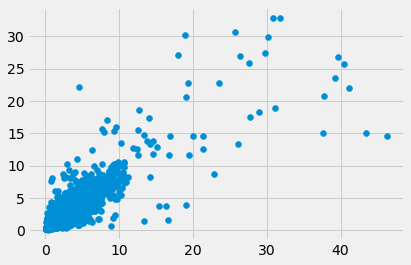

In [536]:
plt.scatter(y_test, y_predrf_f)

In [537]:
features = X_train_f.columns
#get feature importance attributed by random forest model
importance = pd.concat([pd.Series(features),
                       pd.Series(pipe_rf_f['randomforestregressor'].feature_importances_)], axis = 1)

importance.columns = ['feature', 'importance']
importance.sort_values(by = 'importance', ascending = False).head(10)

,feature,importance
0,of_dist,0.2024
1,lc_82,0.1681
2,lc_11,0.1108
3,lc_21,0.0741
4,lc_41,0.0436
8,u_wind_narr,0.0421
5,lc_43,0.0395
9,cl_cover_narr,0.0300
6,za_mean,0.0289
7,lc_24,0.0283


In [554]:
importance.to_csv('importance1.csv')

In [389]:
#HyperTuning

In [539]:
#Set Parameters
params = {}
params['randomforestregressor__max_depth'] = np.arange(1, 1000,50)
params['randomforestregressor__n_estimators'] = np.arange(1, 1000,50)
params['randomforestregressor__max_samples'] = np.arange(1, 1000,50)

In [540]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [541]:
#Grid for hypertuning
gridRF = RandomizedSearchCV(pipe_rf_f, params, cv = 5, n_jobs = -1, random_state = 777, n_iter = 10, scoring = 'r2')

In [542]:
gridRF.fit(X_train_f,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline',
                                                                               Pipeline(steps=[('knnimputer',
                                                                                                KNNImputer(n_neighbors=2)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['of_dist',
                                                                                'lc_82',
                                                                                'lc

In [543]:
gridRF.best_params_

{'randomforestregressor__n_estimators': 351,
 'randomforestregressor__max_samples': 701,
 'randomforestregressor__max_depth': 301}

In [544]:
#Look at model results
results = pd.DataFrame(gridRF.cv_results_)
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__n_estimators,param_randomforestregressor__max_samples,param_randomforestregressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,78.6883,16.3576,6.5197,3.6828,351,701,301,"{'randomforestregressor__n_estimators': 351, 'randomforestregressor__max_samples': 701, 'randomforestregressor__max_depth': 301}",0.6040,0.6284,0.6597,0.6881,0.6917,0.6544,0.0340,1
0,72.4242,7.5568,15.2758,2.0327,351,601,751,"{'randomforestregressor__n_estimators': 351, 'randomforestregressor__max_samples': 601, 'randomforestregressor__max_depth': 751}",0.5880,0.6139,0.6453,0.6722,0.6772,0.6393,0.0341,2
9,81.8672,1.3292,0.9957,0.1817,601,501,501,"{'randomforestregressor__n_estimators': 601, 'randomforestregressor__max_samples': 501, 'randomforestregressor__max_depth': 501}",0.5708,0.5982,0.6260,0.6535,0.6627,0.6222,0.0342,3
3,31.3644,7.8038,10.5451,3.2026,101,451,351,"{'randomforestregressor__n_estimators': 101, 'randomforestregressor__max_samples': 451, 'randomforestregressor__max_depth': 351}",0.5694,0.5877,0.6192,0.6422,0.6470,0.6131,0.0303,4
7,88.6922,4.8264,9.3036,3.5149,451,451,701,"{'randomforestregressor__n_estimators': 451, 'randomforestregressor__max_samples': 451, 'randomforestregressor__max_depth': 701}",0.5603,0.5916,0.6132,0.6437,0.6467,0.6111,0.0325,5


In [545]:
y_pred_final = gridRF.predict(X_test_f)

In [546]:
print(r2_score(y_test, y_pred_final))
print(explained_variance_score(y_test, y_pred_final))
print(np.sqrt(mean_squared_error(y_test, y_pred_final)))

0.555169304195714
0.5559023531181124
1.1944927287084415


In [ ]:
gridRF['randomforestregressor']

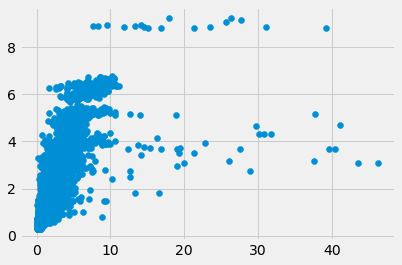

In [547]:
plt.scatter(y_test, y_pred_final);

In [559]:
features = X_train_f.columns
#get feature importance attributed by random forest model
importance = pd.concat([pd.Series(features),
                       pd.Series(gridRF.best_estimator_['randomforestregressor'].feature_importances_)], axis = 1)

importance.columns = ['feature', 'importance']
importance.sort_values(by = 'importance', ascending = False)

,feature,importance
1,lc_82,0.1668
0,of_dist,0.1071
2,lc_11,0.0828
6,za_mean,0.0758
11,week,0.0689
...,...,...
139,NaN,0.0000
271,NaN,0.0000
234,NaN,0.0000
311,NaN,0.0000


In [560]:
importance.to_csv('importances2.csv')

In [548]:
#save models and predictions 
predictions_df = pd.DataFrame()
predictions_df['Actual'] = y_test
predictions_df['gridRF'] = y_pred_final
predictions_df['15feat'] =  y_predrf_f
predictions_df['23feat'] = y_predrf
predictions_df['allfeat'] = y_pred4

In [551]:
predictions_df.to_csv('predictions_df.csv')

In [549]:
import joblib

In [550]:
# save the model to disk
grid = 'grid.sav'
joblib.dump(gridRF, grid)
best = 'best.sav'
joblib.dump(pipe_rf, best)
few_feat = 'few_feat.sav'
joblib.dump(pipe_rf_f, few_feat)

['few_feat.sav']